# Preliminary EDA

In [1]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties
# Auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/work')
BASE_DIR = '/home/work'
DATA_DIR = BASE_DIR + '/data'

PARTITION = 2
PROCESSED_DIR = DATA_DIR + '/processed'
DOWNSAMPLED_USER_DATASET = PROCESSED_DIR + '/user_rating_downsampled.txt'
DOWNLOADED_USER_SONG_DATASET = PROCESSED_DIR + '/user_and_song_rating_downsampled.txt'

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, count, desc, min, max, log, abs, mean, stddev, row_number, rand
from pyspark.sql.window import Window
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.utils import load_file_from_hdfs, cleaned_df


In [4]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[4]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.master', 'local[4]')
('spark.app.id', 'local-1717549090084')
('spark.app.startTime', '1717549089323')
('spark.executor.id', 'driver')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false')
('spark.app.subm

Load choosen partition of song ratings, song attributes, and genre hierarchy.

In [5]:
song_ratings_train_file_path = f"/raw/train/train_{PARTITION}.txt"
song_ratings_train = load_file_from_hdfs(song_ratings_train_file_path)

song_ratings_test_file_path = f"/raw/test/test_{PARTITION}.txt"
song_ratings_test = load_file_from_hdfs(song_ratings_test_file_path)

song_ratings = song_ratings_train.union(song_ratings_test) # combine the train and test partition

song_attributes_file_path = "song-attributes.txt"
song_attributes = load_file_from_hdfs(song_attributes_file_path)

genre_hierarchy_file_path = "genre-hierarchy.txt"
genre_hierarchy = load_file_from_hdfs(genre_hierarchy_file_path)

Call cleaned_df function to get cleaned df from EDA

In [6]:
df = cleaned_df(song_ratings, song_attributes, genre_hierarchy)

root
 |-- user_id: integer (nullable = true)
 |-- song_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- album_id: integer (nullable = true)
 |-- artist_id: integer (nullable = true)
 |-- genre_id: integer (nullable = true)
 |-- genre_name: string (nullable = true)



+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|summary|           user_id|          song_id|            rating|          album_id|         artist_id|          genre_id|       genre_name|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|  count|          78909821|         78909821|          78909821|          78909821|          78909821|          78909821|         78909821|
|   mean|499746.46840439545|68274.02707812504|3.1528440674070213|10361.592222392697|4776.0641216636395|16.666298850177345|             NULL|
| stddev| 57936.75037674207|39459.18779033151|1.6030326088607252| 5906.090895444379| 2680.786813237493| 42.91624825455018|             NULL|
|    min|            400000|                0|                 1|                 0|                 0|                 0|Adult Alternative|
|    max|    

Null Columns in cleaned df: {'user_id': 0, 'song_id': 0, 'rating': 0, 'album_id': 0, 'artist_id': 0, 'genre_id': 0, 'genre_name': 0}


In [7]:
df.count()

78909821

Get users' rating count to ensure balanced distribution of ratings per user.

In [8]:
user_ratings_count = df.groupBy("user_id").count()
user_ratings_count = user_ratings_count.withColumnRenamed("count", "ratings_count")
user_ratings_count.show(10)

+-------+-------------+
|user_id|ratings_count|
+-------+-------------+
| 400003|          266|
| 400129|           60|
| 400152|          108|
| 400301|          375|
| 400440|           36|
| 400612|           67|
| 400735|          312|
| 400797|          161|
| 400833|           69|
| 400982|          687|
+-------+-------------+
only showing top 10 rows



Min and max values of users are quite different. There must be some outliers.

In [9]:
min_max_values = user_ratings_count.select(min("ratings_count").alias("min_value"), max("ratings_count").alias("max_value")).first()

min_value = min_max_values["min_value"]
max_value = min_max_values["max_value"]

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 30
Maximum value: 131533


Distribution is extremely skewed.

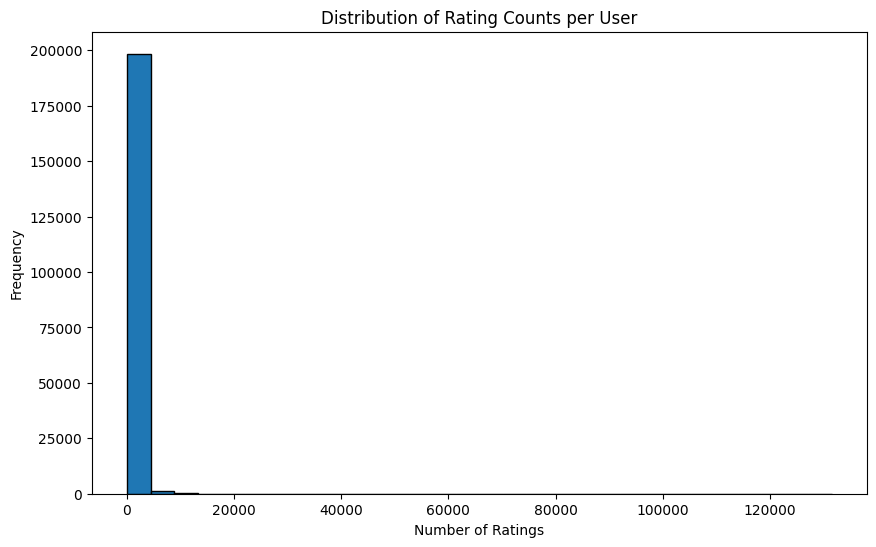

Total number of users: 200000


In [10]:
data= user_ratings_count.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(data['ratings_count'], bins=30, edgecolor='black')
plt.title('Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

total_users = user_ratings_count.count()
print("Total number of users:", total_users)

Use log and z-score in attempts to find outliers.

In [11]:
user_ratings_count[user_ratings_count['ratings_count'] == 0].count() # no zero
user_ratings_count = user_ratings_count.withColumn('log_ratings_count', log(user_ratings_count['ratings_count']))  

In [12]:
mean_log = user_ratings_count.select(mean(col("log_ratings_count"))).collect()[0][0]
stddev_log = user_ratings_count.select(stddev(col("log_ratings_count"))).collect()[0][0]

user_ratings_count = user_ratings_count.withColumn("z_score", (col("log_ratings_count") - mean_log) / stddev_log)
user_ratings_count = user_ratings_count.withColumn("is_outlier", abs(col("z_score")) > 3) # threshold 3

Use IQR, lower bound, upper bound to downsample outliers instead

In [13]:
quantiles = user_ratings_count.approxQuantile("ratings_count", [0.25, 0.5, 0.75], 0.05)
Q1, median, Q3 = quantiles
IQR = Q3 - Q1

# lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print("Upper bound:", upper_bound)

filtered_below_upper_bound = user_ratings_count.filter(col("ratings_count") < upper_bound)
ratings_below_upper_bound = df.join(filtered_below_upper_bound, on="user_id", how="inner")
users_above_upper_bound = user_ratings_count.filter(col("ratings_count") > upper_bound)
ratings_above_upper_bound = df.join(users_above_upper_bound, on="user_id", how="inner")

# Shuffle user ratings above the upper bound
ratings_with_random = ratings_above_upper_bound.withColumn("rand", rand())
window_spec = Window.partitionBy("user_id").orderBy("rand")

# Sample ratings above the upper bound to match the number of ratings at the upper bound
ratings_with_row_number = ratings_with_random.withColumn("row_number", row_number().over(window_spec))
resampled_ratings = ratings_with_row_number.filter(col("row_number") <= upper_bound).drop("rand", "row_number")

downsampled_user_ratings = ratings_below_upper_bound.union(resampled_ratings)

downsampled_user_ratings = downsampled_user_ratings.select("user_id", "song_id", "rating")

print("Data count after downsampling outliers:", downsampled_user_ratings.count())

Upper bound: 724.0


Data count after downsampling outliers: 50296259


Distribution a bit more less skewed.

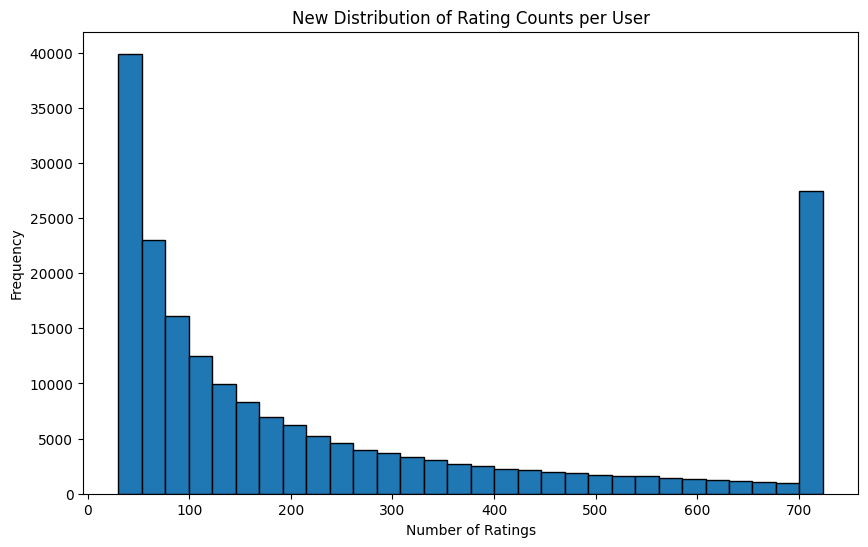

In [14]:
downsampled_user_ratings_counts = downsampled_user_ratings.groupBy("user_id").count()
downsampled_user_ratings_counts = downsampled_user_ratings_counts.withColumnRenamed("count", "ratings_count")
downsampled_user_ratings_counts_data = downsampled_user_ratings_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(downsampled_user_ratings_counts_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

Use stratified downsampling instead. 

In [15]:
# # Divide the users into three strata based on the number of ratings
# low_stratum = user_ratings_count.filter(col("ratings_count") <= Q1)
# low_stratum_ids = low_stratum.select("user_id").distinct().collect()
# medium_stratum = user_ratings_count.filter((col("ratings_count") > Q1) & (col("ratings_count") <= median))
# medium_stratum_ids = medium_stratum.select("user_id").distinct().collect()
# high_stratum = user_ratings_count.filter(col("ratings_count") > median)
# high_stratum_ids = high_stratum.select("user_id").distinct().collect()

# # Define the fraction to downsample each stratum
# fractions_low = {row["user_id"]: 0.1 for row in low_stratum_ids}

# # Downsample each stratum
# low_stratum_ratings = low_stratum.join(df, "user_id", "inner")
# print("Low stratum count:", low_stratum_ratings.count())
# downsampled_low_stratum = low_stratum_ratings.sampleBy("user_id", fractions={fractions_low}, seed=42)
# print("Downsampled Low stratum count:", downsampled_low_stratum.count())
# medium_stratum_ratings = medium_stratum.join(df, "user_id", "inner")
# print("Medium stratum count:", medium_stratum_ratings.count())
# downsampled_medium_stratum = medium_stratum_ratings.sampleBy("user_id", fractions={fractions_medium}, seed=42)
# print("Medium stratum count:", downsampled_medium_stratum.count())
# high_stratum_ratings = high_stratum.join(df, "user_id", "inner")
# print("High stratum count:", high_stratum_ratings.count())
# downsampled_high_stratum = high_stratum_ratings.sampleBy("user_id", fractions={fractions_high}, seed=42)
# print("High stratum count:", downsampled_high_stratum.count())

# # Combine the downsampled strata
# downsampled_user_counts = downsampled_low_stratum.union(downsampled_medium_stratum).union(downsampled_high_stratum)


Save downsampled user ratings dataset to local. 

In [16]:
# Save Train to local
downsampled_user_ratings = downsampled_user_ratings.coalesce(1)
downsampled_user_ratings.write.csv(f"file://{PROCESSED_DIR}/temp", header=False, mode="overwrite", sep="\t")

In [17]:
# Move to single file
! rm -rf $DOWNSAMPLED_USER_DATASET
! mv $PROCESSED_DIR/temp/part-00000* $DOWNSAMPLED_USER_DATASET

# Clean up
! rm -rf $PROCESSED_DIR/temp

Balance song distribution in same manner as user distribution.

In [18]:
song_ratings_count = df.groupBy("song_id").count()
song_ratings_count = song_ratings_count.withColumnRenamed("count", "ratings_count")
song_ratings_count.show()

+-------+-------------+
|song_id|ratings_count|
+-------+-------------+
|  34759|        11156|
|  43527|          126|
|  67376|         4366|
|  67753|          390|
|  80332|         2808|
| 113000|         4553|
| 117437|         1349|
| 133524|          157|
| 126373|          925|
|   1238|         4981|
|  47084|          881|
|   4935|         2878|
|  25591|          135|
|  29601|         2290|
|  38422|          136|
|  45341|          869|
|  47711|         1125|
|  82730|         1470|
|  93341|         2060|
| 128589|          211|
+-------+-------------+
only showing top 20 rows



In [19]:
min_max_values = song_ratings_count.select(min("ratings_count").alias("min_value"), max("ratings_count").alias("max_value")).first()

min_value = min_max_values["min_value"]
max_value = min_max_values["max_value"]

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 74
Maximum value: 36810


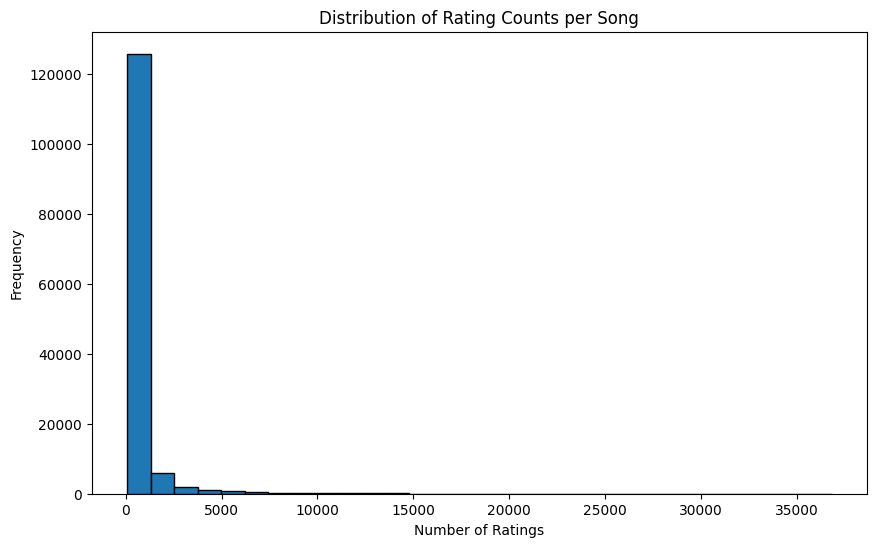

Total number of songs rated: 136736


In [20]:
data = song_ratings_count.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(data['ratings_count'], bins=30, edgecolor='black')
plt.title('Distribution of Rating Counts per Song')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

total_songs = song_ratings_count.count()
print("Total number of songs rated:", total_songs)

In [21]:
downsampled_user_ratings = downsampled_user_ratings.select("user_id", "song_id", "rating")

print("Data count after downsampling outliers:", downsampled_user_ratings.count())

quantiles = song_ratings_count.approxQuantile("ratings_count", [0.25, 0.5, 0.75], 0.05)
Q1, median, Q3 = quantiles
IQR = Q3 - Q1

# lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print("Upper bound:", upper_bound)

# filtered_song_df = song_ratings_count.filter((col("ratings_count") >= lower_bound) & (col("ratings_count") <= upper_bound))
filtered_below_upper_bound = song_ratings_count.filter(col("ratings_count") < upper_bound)
ratings_below_upper_bound = df.join(filtered_below_upper_bound, on="song_id", how="inner")
songs_above_upper_bound = song_ratings_count.filter(col("ratings_count") > upper_bound)
ratings_above_upper_bound = df.join(songs_above_upper_bound, on="song_id", how="inner")

# Shuffle song ratings above the upper bound
ratings_with_random = ratings_above_upper_bound.withColumn("rand", rand())
window_spec = Window.partitionBy("song_id").orderBy("rand")

# Sample ratings above the upper bound to match the number of ratings at the upper bound
ratings_with_row_number = ratings_with_random.withColumn("row_number", row_number().over(window_spec))
resampled_ratings = ratings_with_row_number.filter(col("row_number") <= upper_bound).drop("rand", "row_number")

downsampled_song_ratings = ratings_below_upper_bound.union(resampled_ratings)
print("Data count after downsampling song outliers:", downsampled_song_ratings.count())

Data count after downsampling outliers: 50296259


Upper bound: 794.5


Data count after downsampling song outliers: 46443280


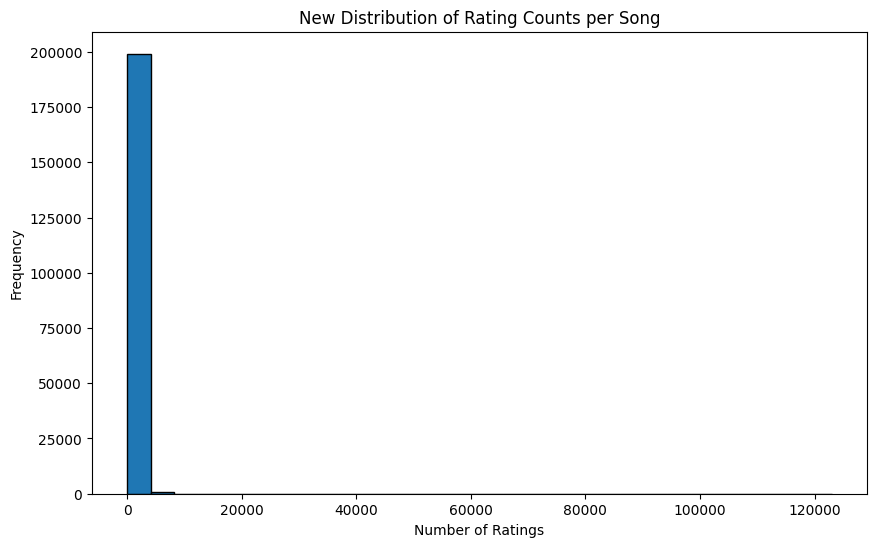

In [22]:
downsampled_song_ratings_counts = downsampled_song_ratings.groupBy("song_id").count()
downsampled_song_ratings_counts = downsampled_song_ratings_counts.withColumnRenamed("count", "ratings_count")
downsampled_song_ratings_counts_data = downsampled_song_ratings_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(downsampled_song_ratings_counts_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per Song')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

Join downsampled user ratings and downsampled song ratings dataset. 

In [24]:
filtered_user_song_df = downsampled_user_ratings.join(downsampled_song_ratings, on=["user_id", "song_id"], how="inner")
filtered_user_song_df = filtered_user_song_df.select("user_id", "song_id", downsampled_user_ratings["rating"])
print("Dataset after joining downsampled user/song outliers:", filtered_user_song_df.count())

Dataset after joining downsampled user/song outliers: 26958644


Save downsampled user and song rating dataset.

In [25]:
# Save to local
filtered_user_song_df = filtered_user_song_df.coalesce(1)
filtered_user_song_df.write.csv(f"file://{PROCESSED_DIR}/temp", header=False, mode="overwrite", sep="\t")

In [26]:
# Move to single file
! rm -rf $DOWNLOADED_USER_SONG_DATASET
! mv $PROCESSED_DIR/temp/part-00000* $DOWNLOADED_USER_SONG_DATASET

# Clean up
! rm -rf $PROCESSED_DIR/temp

19:09:27.753 [dispatcher-BlockManagerMaster] ERROR org.apache.spark.rpc.netty.Inbox - Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56) ~[spark-common-utils_2.12-3.5.0.jar:3.5.0]
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310) ~[spark-core_2.12-3.5.0.jar:3.5.0]
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75) ~[spark-core_2.12-3.5.0.jar:3.5.0]
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102) ~[spark-core_2.12-3.5.0.jar:3.5.0]
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110) ~[spark-core_2.12-3.5.0.jar:3.5.0]
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36) ~[spark-core_2.12-3.5.0.jar:3.5.0]
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124) ~[spark-core_2.12-3.5.0.jar:3.5.0]
	at org.apache.spark.stor